In [1]:
import os
print(os.getcwd())
import sys
print(sys.executable)

/home/sharedgroup
/home/sharedgroup/anaconda3/envs/tf_gpu_3.9/bin/python3


In [2]:
import os
import tensorflow as tf
import cv2
import numpy as np

from PIL import Image
from sklearn.model_selection import train_test_split


2023-05-23 16:53:27.459113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


2023-05-23 16:53:29.007421: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-23 16:53:29.008960: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-23 16:53:29.065636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 16:53:29.065888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-23 16:53:29.065917: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-23 16:53:29.068835: I tensorflow/stream_executor/platfor

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2023-05-23 16:53:29.123502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found GPU at: /device:GPU:0


2023-05-23 16:53:29.124470: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-23 16:53:29.124819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 16:53:29.125257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-23 16:53:29.125310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-23 16:53:29.125389: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-23 16:53:29.125436: I tensorflow/stream_executor/plat

### Loading JPEG images and their masks
We create a general import function.

In [5]:
def image_importer(directory: str, filetype: str):
    """
    Imports images from a given directory and ensures them to be of size (1080, 1920, 3).
    :param directory: The path to the directory
    :return: list of all images
    """
    image_list = []
    for i in range(1, len(os.listdir(directory))):
        file = f'Amateur{i}.{filetype}'
        image = cv2.imread(os.path.join(directory, file))

        # Resize to (1080, 1920, 3) if not this size.
        height, width, channels = image.shape
        if width < 1920:
            image = cv2.resize(image, (1920, 1080), interpolation=cv2.INTER_LINEAR)
        image_list.append(image)

    return image_list

Load in the images

In [6]:
jpeg_directory = './datasets_advanced/output/JPEGImages'
jpeg_images = image_importer(jpeg_directory, 'jpg')

mask_directory = './datasets_advanced/output/SegmentationClassPNG'
mask_images = image_importer(mask_directory, 'png')

Check if the JPEG and mask images looks good

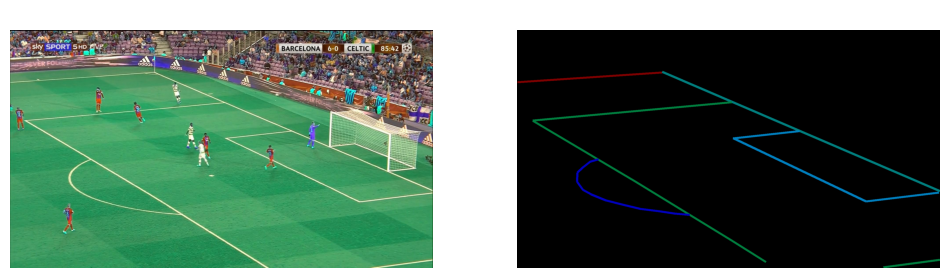

In [7]:
from matplotlib import pyplot as plt
import random

plt.figure(figsize=(12, 6))

image_number = random.randint(0, len(jpeg_images)-1)
plt.subplot(121)
plt.imshow(jpeg_images[image_number])
plt.axis("off")
plt.title("Image", color = "white")

plt.subplot(122)
plt.imshow(mask_images[image_number])
plt.axis("off")
plt.title("Mask", color = "white")
plt.show()

Load the labels

In [8]:
# Load the label data from npy file
labels_directory = './datasets_advanced/output/SegmentationClass'
labels_list = []

for i in range(1, len(os.listdir(labels_directory)) + 1):
    file = f'Amateur{i}.npy'
    label = np.load(os.path.join(labels_directory, file))

    # Append to label if the width is not 1920
    if label.shape[1] != 1920:
        padding_width = 1920 - label.shape[1]
        label = np.pad(label, ((0, 0), (0, padding_width)), 'constant')
    labels_list.append(label)

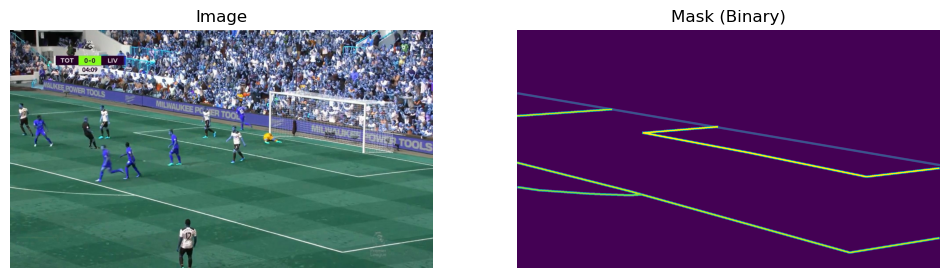

In [9]:
from matplotlib import pyplot as plt
import random

plt.figure(figsize=(12, 6))

image_number = random.randint(0, len(jpeg_images)-1)
plt.subplot(121)
plt.imshow(jpeg_images[image_number])
plt.axis("off")
plt.title("Image")

plt.subplot(122)
plt.imshow(labels_list[image_number])
plt.axis("off")
plt.title("Mask (Binary)")
plt.show()

### Prepare for unet (conversion to np.array and train test split)

In [10]:
jpeg_images = np.array(jpeg_images)
mask_images = np.array(mask_images)
labels_list = np.array(labels_list)

Train-test split

In [14]:
labels_list = np.where(labels_list > 1, 1, labels_list)
labels_list = np.expand_dims(labels_list, axis=-1)

X_train, X_val, y_train, y_val = train_test_split(
    jpeg_images, labels_list,
    test_size=0.2, random_state=0
)

In [17]:
del jpeg_images,mask_images, labels_list

### Data Augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(horizontal_flip=True,
                             brightness_range=[0.8,1.2],
                             zoom_range=[.7,1.],
                             fill_mode='nearest')

mask_datagen = ImageDataGenerator(horizontal_flip=True,
                             # brightness_range=[0.15,1.3],
                             zoom_range=[.7,1.],
                             fill_mode='nearest')

In [19]:
seed = 1
batch_size=8

image_gen = image_datagen.flow(X_train, seed=seed, batch_size=batch_size)
mask_gen = mask_datagen.flow(y_train, seed=seed, batch_size=batch_size)

float32
float32
199065600
66355200


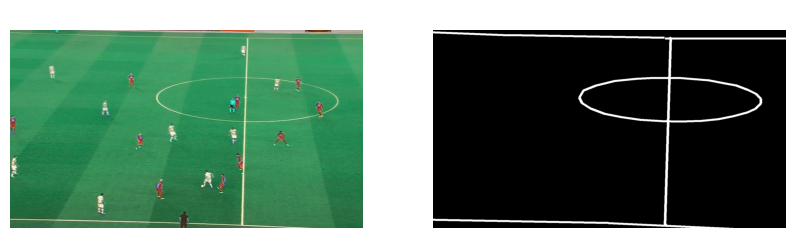

In [21]:
x = image_gen.next()
y = mask_gen.next()

print(x.dtype)
print(y.dtype)
print(x.nbytes)
print(y.nbytes)
for i in range(1):
    image = x[i]
    mask = y[i]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title('Augmented Image', color='white')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title('Augmented Mask', color='white')
    axs[1].axis('off')

    plt.show()


### Testing Data Augmentation

In [22]:
# datagen = ImageDataGenerator(horizontal_flip=True,
#                              brightness_range=[0.15,1.3],
#                              zoom_range=[0.5,1.5],
#                              fill_mode='constant')
# train_generator = datagen.flow(X_train, batch_size=1)
# rows = 3
# columns = 3
# fig, axes = plt.subplots(rows,columns)
# for r in range(rows):
#     for c in range(columns):
#         image_batch = train_generator.next()
#         image = image_batch[0].astype('uint8')
#         axes[r,c].imshow(image)
# fig.set_size_inches(15,10)

Mask Generation

In [23]:
def image_mask_generator(image_gen, mask_gen,dtype = np.float16):
    train_gen = zip(image_gen, mask_gen)
    for (img, mask) in train_gen:
        yield (img.astype(dtype), mask.astype(dtype))

my_generator = image_mask_generator(image_gen, mask_gen)

### U-Net Architecture

In [24]:
def convolutional_part(input, n_filters):
    """
    Creates the convolutional part of the U-Net. Returns the "copied_output" which is copied to the symmetrical side of
    the U-Net
    """

    # 1st layer
    copied_output = Conv2D(n_filters, (3,3), padding="same", activation= "relu")(input)
    # copied_output = BatchNormalization()(copied_output)
    # 2nd layer
    copied_output = Conv2D(n_filters, (3,3), padding="same", activation="relu")(copied_output)
    # copied_output = BatchNormalization()(copied_output)

    return copied_output

In [25]:
from tensorflow.keras.layers import MaxPool2D


def contraction_block(input, n_filters):
    """
    Creates the contraction part of the U-Net. Returns the "copied_output" which is copied to the symmetrical side of
    the U-Net and "max_pooling_output" which is the output of max pooling operation downsampling in the U-Net.
    """

    copied_output = convolutional_part(input, n_filters)
    max_pooling_output = MaxPool2D((2,2), strides=2)(copied_output)

    return copied_output, max_pooling_output

In [26]:
from tensorflow.keras.layers import Conv2DTranspose, Concatenate


def expansion_block(input, skip_connections , n_filters):
    """
    Creates the expansion part of the U-Net. Returns the "expansion_output" which is the output of upsampling operation
    in the U-Net.
    """
    expansion_output = Conv2DTranspose(n_filters, (2, 2), strides=2, padding="same")(input)
    expansion_output = Concatenate()([expansion_output, skip_connections])
    expansion_output = convolutional_part(expansion_output, n_filters)

    return expansion_output

In [27]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Model, Input


def build_unet(input_shape, number_output_classes):
    """ Building U-Net using the functions above. "s" stands for skipped connection, "cl" stands for contraction level,
     "b" stands for bridge, "el" stands for expansion level.
    """

    inputs = Input(input_shape)

    # Down sampling
    s1, cl1 = contraction_block(inputs, 16)
    s2, cl2 = contraction_block(cl1, 32)
    s3, cl3 = contraction_block(cl2, 64)
    # s4, cl4 = contraction_block(cl3, 512)

    # Bridge
    b1 = convolutional_part(cl3, 128)

    # Up sampling
    # el1 = expansion_block(b1, s4, 512)
    el2 = expansion_block(b1, s3, 64)
    el3 = expansion_block(el2, s2, 32)
    el4 = expansion_block(el3, s1, 16)

    outputs = Conv2D(number_output_classes, (1,1), padding="same", activation="sigmoid")(el4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [28]:
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(y_true, y_pred):
    # Define weights
    weight_for_0 = tf.constant(1.0, dtype=tf.float32)  # for 'not a line'
    weight_for_1 = tf.constant(20.0, dtype=tf.float32)  # for 'line' (10 times more important)

    # Cast y_true and y_pred to the correct type (float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * weight_for_1 + (1. - y_true) * weight_for_0
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)





In [29]:
from tensorflow.keras.optimizers import Adam

input = (X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2])
number_output_classes = 1

model=build_unet(input,number_output_classes)
model.compile(optimizer=Adam(learning_rate = 1e-5), loss=weighted_binary_crossentropy, metrics=['accuracy'])
model.summary()

2023-05-23 16:54:32.500394: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-23 16:54:32.500937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 16:54:32.501364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-05-23 16:54:32.501458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-23 16:54:32.501896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-23 16:54:32.501922: I tensorflow/stream_executor/plat

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1080, 1920,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1080, 1920, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1080, 1920, 1 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 540, 960, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [30]:
# from tensorflow.keras.utils import plot_model
# plot_model(model)

In [31]:
batch_size = 8
epochs = 1000
steps_per_epoch = 10

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_filepath = 'best_model_advanced.h5'

earlystopping = EarlyStopping(monitor='val_loss', patience=6, min_delta = 0.01)

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True,
                                   monitor='val_loss', mode='min')






In [33]:
history = model.fit(my_generator, batch_size=batch_size, epochs=epochs,
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopping, model_checkpoint])

2023-05-23 16:54:44.415200: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-23 16:54:44.415651: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2593570000 Hz


Epoch 1/1000


2023-05-23 16:54:46.267224: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-23 16:54:47.458181: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-05-23 16:54:47.521401: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-05-23 16:54:47.991124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


10/10 [==============================] - 93s 7s/step - loss: 1.7318 - accuracy: 0.2135 - val_loss: 1.6570 - val_accuracy: 0.3105
Epoch 2/1000
10/10 [==============================] - 40s 4s/step - loss: 1.5080 - accuracy: 0.3359 - val_loss: 1.4388 - val_accuracy: 0.4973
Epoch 3/1000
10/10 [==============================] - 48s 5s/step - loss: 1.3428 - accuracy: 0.5323 - val_loss: 1.3453 - val_accuracy: 0.6949
Epoch 4/1000
10/10 [==============================] - 45s 5s/step - loss: 1.2891 - accuracy: 0.6849 - val_loss: 1.3112 - val_accuracy: 0.7641
Epoch 5/1000
10/10 [==============================] - 44s 4s/step - loss: 1.3404 - accuracy: 0.7556 - val_loss: 1.2936 - val_accuracy: 0.7764
Epoch 6/1000
10/10 [==============================] - 44s 5s/step - loss: 1.2432 - accuracy: 0.7959 - val_loss: 1.2800 - val_accuracy: 0.7730
Epoch 7/1000
10/10 [==============================] - 46s 5s/step - loss: 1.2263 - accuracy: 0.7925 - val_loss: 1.2714 - val_accuracy: 0.7641
Epoch 8/1000
10/10 

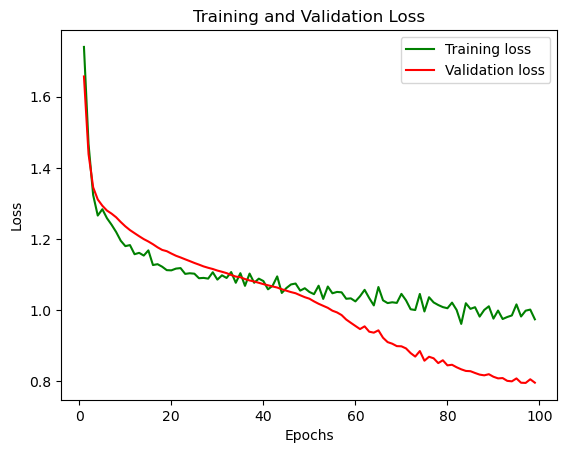

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

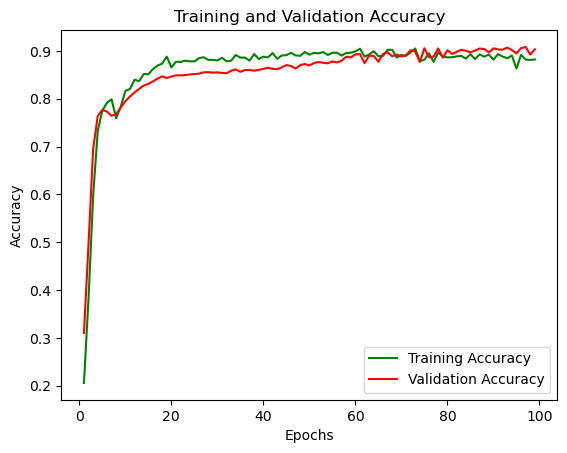

In [38]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Trial

In [39]:
from sklearn.metrics import log_loss

In [40]:
loaded_model=build_unet(input,number_output_classes)
loaded_model.compile(optimizer=Adam(learning_rate = 1e-5), loss=weighted_binary_crossentropy, metrics=['accuracy'])

loaded_model.load_weights('best_model_advanced.h5')
print(np.shape(X_val))
print(np.shape(y_val))

(22, 1080, 1920, 3)
(22, 1080, 1920, 1)


In [57]:
# Choose a single image from the validation or test set
number = 9
image = X_val[number:number+1,:,:,:]  # Replace with the index of the desired image
print(np.shape(image))
ground_truth_mask = y_val[number:number+1,:,:,:]  # Replace with the index of the corresponding ground truth mask

# Reshape the image if necessary
#image = np.reshape(image, (1,) + image.shape)

# Make prediction on the image
prediction = loaded_model.predict(image)

print(ground_truth_mask)
print(prediction)

flattened_ground_truth = ground_truth_mask.flatten()
flattened_prediction = prediction.flatten()
print(log_loss(flattened_ground_truth, flattened_prediction))
# Post-process the prediction and ground truth masks
threshold = 0.5
prediction_binary = np.where(prediction > threshold, 1, 0)
# print(prediction_binary)
# ground_truth_binary = np.where(ground_truth_mask > threshold, 1, 0)

(1, 1080, 1920, 3)
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]]
[[[[0.2703 ]
   [0.6216 ]
   [0.2415 ]
   ...
   [0.256  ]
   [0.509  ]
   [0.4707 ]]

  [[0.0801 ]
   [0.457  ]
   [0.2915 ]
   ...
   [0.0868 ]
   [0.3035 ]
   [0.355  ]]

  [[0.3884 ]
   [0.2443 ]
   [0.1987 ]
   ...
   [0.0955 ]
   [0.458  ]
   [0.3289 ]]

  ...

  [[0.702  ]
   [0.4543 ]
   [0.691  ]
   ...
   [0.888  ]
   [0.2231 ]
   [0.03062]]

  [[0.10876]
   [0.03204]
   [0.7554 ]
   ...
   [0.606  ]
   [0.774  ]
   [0.9243 ]]

  [[0.92   ]
   [0.3535 ]
   [0.4656 ]
   ...
   [0.441  ]
   [0.6807 ]
   [0.942  ]]]]
0.4049495750462086


In [58]:
non_zeros_count = np.count_nonzero(prediction_binary)
print(f"ratio of non-zero: {non_zeros_count/prediction_binary.size}")

ratio of non-zero: 0.09398630401234567


ratio of non-zero: 0.027490837191358024


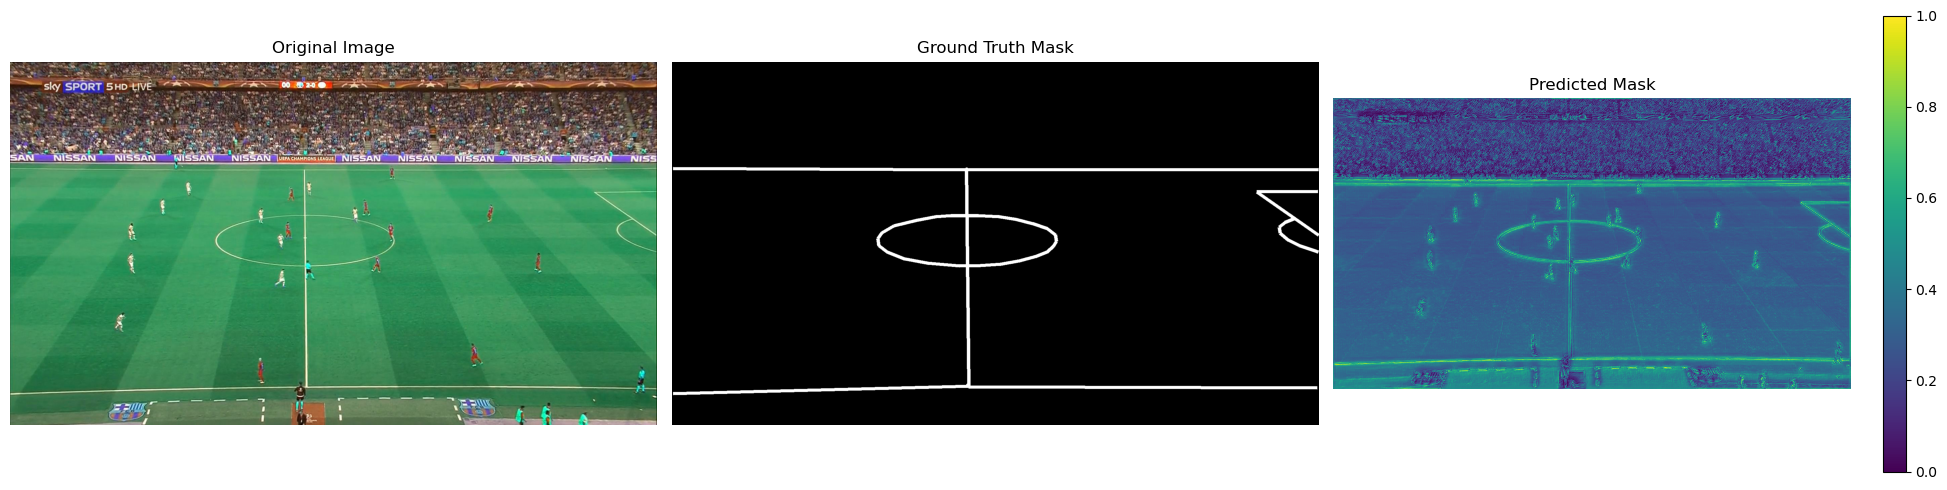

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))  # Increase figure size for better visibility

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Ground Truth Mask")

non_zeros_count = np.count_nonzero(ground_truth_mask)
print(f"ratio of non-zero: {non_zeros_count/ground_truth_mask.size}")

plt.subplot(1, 3, 3)
img = plt.imshow(prediction.squeeze(), cmap='viridis')
plt.axis("off")
plt.title("Predicted Mask")

plt.colorbar(img, ax=plt.gca())  # Add colorbar for the last image

plt.tight_layout()
plt.show()


ratio of non-zero: 0.027490837191358024


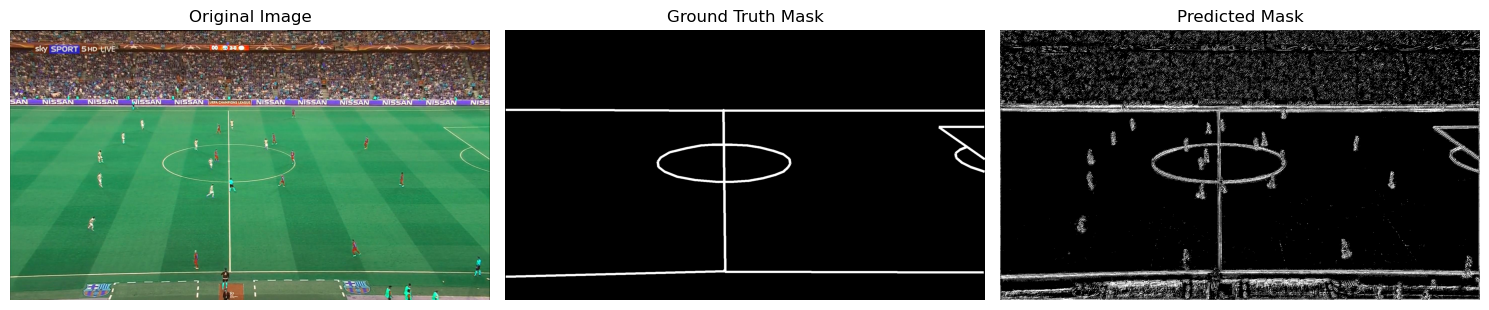

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Increase figure size for better visibility

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Ground Truth Mask")

non_zeros_count = np.count_nonzero(ground_truth_mask)
print(f"ratio of non-zero: {non_zeros_count/ground_truth_mask.size}")

plt.subplot(1, 3, 3)
img = plt.imshow(prediction_binary.squeeze(), cmap='gray')
plt.axis("off")
plt.title("Predicted Mask")

# plt.colorbar(img, ax=plt.gca())  # Add colorbar for the last image

plt.tight_layout()
plt.show()


### Metrics

IoU / Pixel Accuracy Score 

In [61]:
y_pred=loaded_model.predict(X_val)
threshold=0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)


In [62]:
def evaluate_masks(predicted_masks, ground_truth_masks):
    iou_scores = []
    dice_scores = []
    pixel_accuracy = []

    for i in range(len(predicted_masks)):
        pred_mask = predicted_masks[i]
        gt_mask = ground_truth_masks[i]

        intersection = np.logical_and(pred_mask, gt_mask)
        union = np.logical_or(pred_mask, gt_mask)

        iou = np.sum(intersection) / np.sum(union)
        dice = (2.0 * np.sum(intersection)) / (np.sum(pred_mask) + np.sum(gt_mask))
        accuracy = np.mean(pred_mask == gt_mask)

        iou_scores.append(iou)
        dice_scores.append(dice)
        pixel_accuracy.append(accuracy)

    mean_iou = np.mean(iou_scores)
    mean_dice_scores = np.mean(dice_scores)
    mean_pixel_accuracy = np.mean(pixel_accuracy)
    
    print("Mean IoU:", mean_iou)
    print("Mean Dice Scores:", mean_dice_scores)
    print("Mean Pixel Accuracy:", mean_pixel_accuracy)

In [63]:
evaluate_masks(y_pred_binary, y_val)

Mean IoU: 0.1448923411812606
Mean Dice Scores: 0.24956896815637997
Mean Pixel Accuracy: 0.9081920770202019


In [64]:
from sklearn.metrics import confusion_matrix

def compute_fpr_fnr(y_pred, ground_truth_masks):
    num_masks = len(y_pred)
    all_y_pred = np.concatenate(y_pred)
    all_ground_truth = np.concatenate(ground_truth_masks)
    
    cm = confusion_matrix(all_ground_truth.flatten(), all_y_pred.flatten())
    tn, fp, fn, tp = cm.ravel()
    
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("False Positive Rate (FPR):", fpr)
    print("False Negative Rate (FNR):", fnr)


In [65]:
compute_fpr_fnr(y_pred_binary, y_val)

False Positive Rate (FPR): 0.08295871128592462
False Negative Rate (FNR): 0.44357329107490123
